In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

Epoch 1/50, Training Loss: 1.1272639036178589, Validation Loss: 1.1018106937408447
Epoch 2/50, Training Loss: 1.036173939704895, Validation Loss: 0.9254764914512634
Epoch 3/50, Training Loss: 0.9437917272249857, Validation Loss: 0.8735686540603638
Epoch 4/50, Training Loss: 0.8543540239334106, Validation Loss: 0.8572592735290527
Epoch 5/50, Training Loss: 0.7187626957893372, Validation Loss: 0.8366691470146179
Epoch 6/50, Training Loss: 0.6630857586860657, Validation Loss: 0.832351565361023
Epoch 7/50, Training Loss: 0.5182953675587972, Validation Loss: 0.7375537157058716
Epoch 8/50, Training Loss: 0.467692772547404, Validation Loss: 0.6636096239089966
Epoch 9/50, Training Loss: 0.3680814305941264, Validation Loss: 0.5531740188598633
Epoch 10/50, Training Loss: 0.30835150678952533, Validation Loss: 0.5286594033241272
Epoch 11/50, Training Loss: 0.26065481702486676, Validation Loss: 0.5276014804840088
Epoch 12/50, Training Loss: 0.24771767854690552, Validation Loss: 0.5162360668182373
E

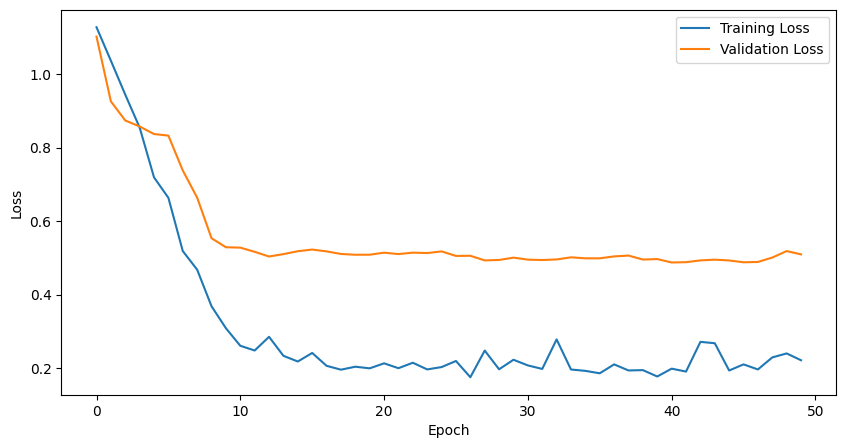

In [5]:
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.resnet50 = resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

class CustomDataset(Dataset):
    def __init__(self, data_dir, annotation_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        self.annotations = annotations['annotations']
        self.images_info = annotations['images']

        # Adapter les étiquettes si nécessaire
        self.adjust_labels()

    def adjust_labels(self):
        for annotation in self.annotations:
            annotation['category_id'] -= 1  # Réduire les étiquettes d'un afin qu'elles soient dans la plage de 0 à 2

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations[idx]['image_id']
        img_info = next((img for img in self.images_info if img['id'] == img_id), None)
        img_path = os.path.join(self.data_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        category = self.annotations[idx]['category_id']

        return image, category

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data_dir = "/content/drive/MyDrive/cn.v1i.coco-mmdetection/train"
train_annotation_file = "/content/drive/MyDrive/_annotations.coco.json"
val_data_dir = "/content/drive/MyDrive/cn.v1i.coco-mmdetection/valid"
val_annotation_file = "/content/drive/MyDrive/_annotations2.coco.json"

train_dataset = CustomDataset(train_data_dir, train_annotation_file, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(val_data_dir, val_annotation_file, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = VehicleClassifier(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_dataloader))

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    val_losses.append(val_loss/len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    scheduler.step()

torch.save(model.state_dict(), "Nationality_classifier.pth")

print("Modèle sauvegardé :")
print(model)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
import json
import os

class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.resnet50 = resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

class CustomDataset(Dataset):
    def __init__(self, data_dir, annotation_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        self.annotations = annotations['annotations']
        self.images_info = annotations['images']

        # Adapter les étiquettes si nécessaire
        self.adjust_labels()

    def adjust_labels(self):
        for annotation in self.annotations:
            annotation['category_id'] -= 1  # Réduire les étiquettes d'un afin qu'elles soient dans la plage de 0 à 2

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations[idx]['image_id']
        img_info = next((img for img in self.images_info if img['id'] == img_id), None)
        img_path = os.path.join(self.data_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        category = self.annotations[idx]['category_id']

        return image, category

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data_dir = "/content/drive/MyDrive/cn.v1i.coco-mmdetection/test"
test_annotation_file = "/content/drive/MyDrive/_annotations3.coco.json"

test_dataset = CustomDataset(test_data_dir, test_annotation_file, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = VehicleClassifier(num_classes=3)
model.load_state_dict(torch.load("Nationality_classifier.pth"))
model.eval()

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def test_image(image, label):
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    loss = criterion(output, label)
    _, predicted = torch.max(output, 1)
    return predicted.item(), loss.item()

for idx, (image, label) in enumerate(test_dataloader):
    predicted_id, loss = test_image(image, label)
    print(f"Image {idx+1}, Predicted ID: {predicted_id}, Loss: {loss}")


Image 1, Predicted ID: 1, Loss: 0.36065030097961426
Image 2, Predicted ID: 2, Loss: 0.9460917711257935
Image 3, Predicted ID: 1, Loss: 0.8128925561904907
Image 4, Predicted ID: 0, Loss: 1.2507128715515137
Image 5, Predicted ID: 1, Loss: 2.6845998764038086


In [26]:
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.resnet50 = resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

class CustomDataset(Dataset):
    def __init__(self, data_dir, annotation_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        self.annotations = annotations['annotations']
        self.images_info = annotations['images']

        self.adjust_labels()

    def adjust_labels(self):
        for annotation in self.annotations:
            annotation['category_id'] -= 1

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations[idx]['image_id']
        img_info = next((img for img in self.images_info if img['id'] == img_id), None)
        img_path = os.path.join(self.data_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        category = self.annotations[idx]['category_id']

        return image, category

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Modifiez le chemin vers votre image externe
external_image_path = "/content/sample_data/tu8.jpg"

# Chargez l'image
external_image = Image.open(external_image_path).convert("RGB")

# Appliquez les transformations
external_image = transform(external_image)

# Ajoutez une dimension supplémentaire pour le lot
external_image = external_image.unsqueeze(0)

# Créez une instance du modèle
model = VehicleClassifier(num_classes=3)

# Chargez les poids du modèle entraîné
model.load_state_dict(torch.load("Nationality_classifier.pth"))

# Mettez le modèle en mode évaluation
model.eval()

# Déterminez le dispositif à utiliser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Passez l'image à travers le modèle
with torch.no_grad():
    external_image = external_image.to(device)
    output = model(external_image)
    _, predicted = torch.max(output, 1)
    predicted_id = predicted.item()

# Affichez l'ID de la classe prédite
print(f"Predicted ID: {predicted_id}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/tu8.jpg'